In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

# 모델에 사용할 데이터 불러오기

In [ ]:
image_dir = Path('/content/drive/MyDrive/2023 KUIAI 해커톤/Data/Season/man')

In [ ]:
image_dir

PosixPath('/content/drive/MyDrive/2023 KUIAI 해커톤/Data/Season/man')

In [ ]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

In [ ]:
images

,Filepath,Label
0,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,spring
1,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,spring
2,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,spring
3,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,spring
4,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,spring
...,...,...
1521,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,winter
1522,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,winter
1523,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,winter
1524,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,winter


In [ ]:
images.Label.value_counts()

summer    635
winter    408
autumn    342
spring    141
Name: Label, dtype: int64

# Train / Test Split & 모델 신경망 구축 by Resnet50 with pretrained layer 호출

In [ ]:
train_df, test_df = train_test_split(images, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)


In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 855 validated image filenames belonging to 4 classes.
Found 213 validated image filenames belonging to 4 classes.
Found 458 validated image filenames belonging to 4 classes.


In [ ]:
pretrained_model = tf.keras.applications.resnet50.ResNet50(
                    input_shape=(224, 224, 3),
                    include_top=False,
                    weights='imagenet',
                    pooling='avg')

pretrained_model.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(50, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# 모델 학습 with Early Stopping / Epoch : 25

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
history = model.fit(train_images,validation_data=val_images,epochs=25,callbacks=[callbacks])


Epoch 1/25
27/27 [==============================] - 276s 10s/step - loss: 1.0349 - accuracy: 0.5591 - val_loss: 0.8230 - val_accuracy: 0.6714
Epoch 2/25
27/27 [==============================] - 145s 5s/step - loss: 0.7487 - accuracy: 0.6702 - val_loss: 0.7649 - val_accuracy: 0.7042
Epoch 3/25
27/27 [==============================] - 145s 5s/step - loss: 0.6172 - accuracy: 0.7450 - val_loss: 0.8216 - val_accuracy: 0.6761
Epoch 4/25
27/27 [==============================] - 145s 5s/step - loss: 0.5428 - accuracy: 0.7766 - val_loss: 0.9633 - val_accuracy: 0.6103
Epoch 5/25
27/27 [==============================] - 145s 5s/step - loss: 0.5093 - accuracy: 0.7906 - val_loss: 0.9155 - val_accuracy: 0.6620


In [ ]:
results = model.evaluate(test_images, verbose=0)
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100,2)}%")

[0.7859780788421631, 0.663755476474762]
Test Accuracy: 66.38%


In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)
matrix = confusion_matrix(test_images.labels, predictions)
report= classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

15/15 [==============================] - 64s 4s/step


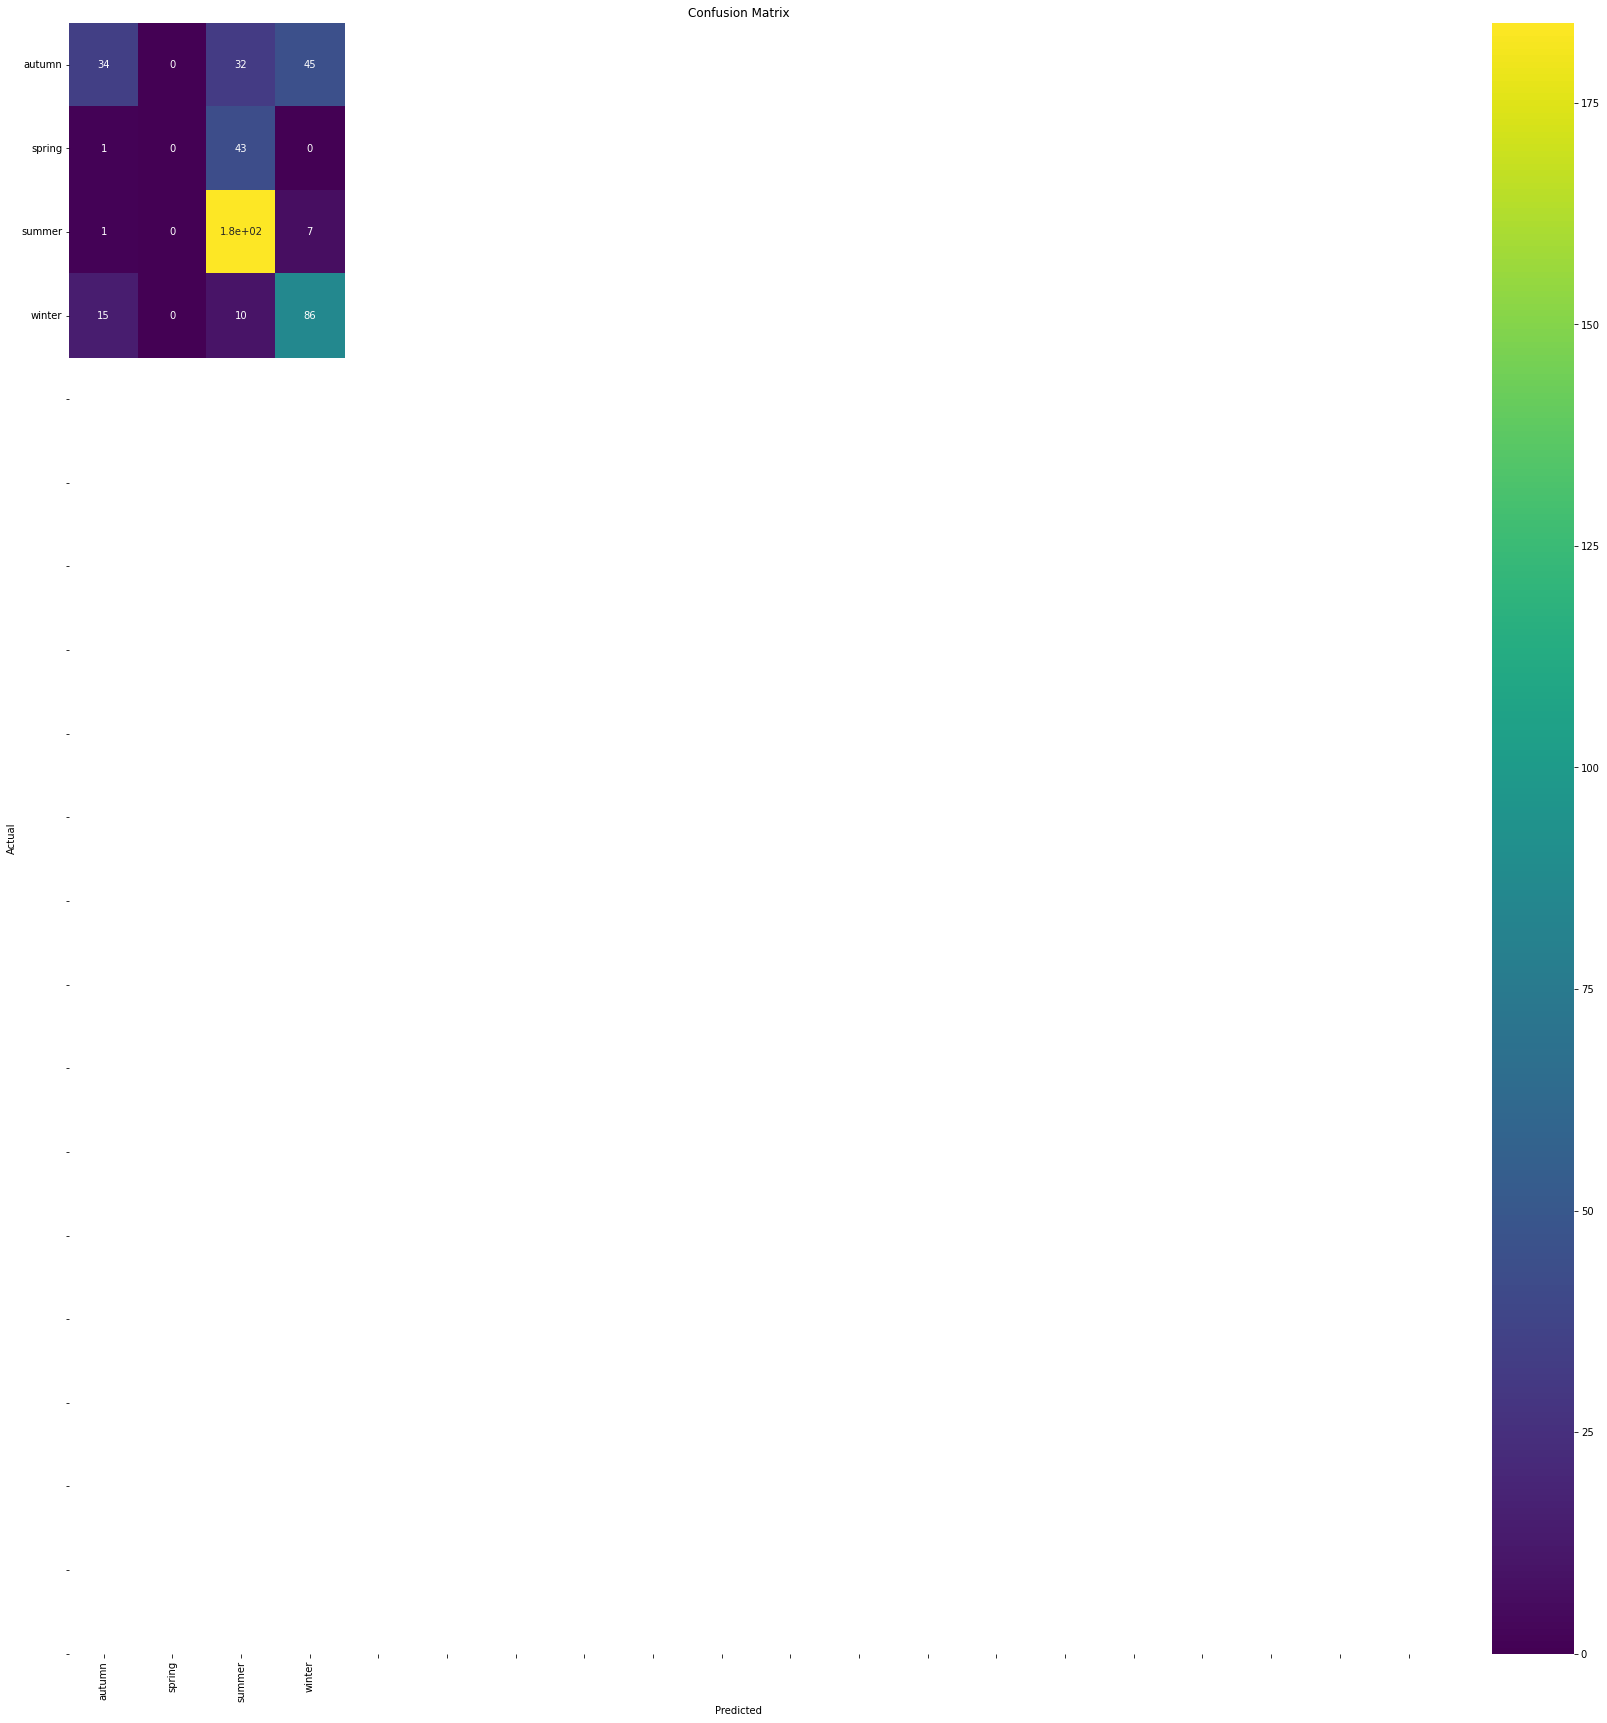

In [ ]:
fig = plt.figure(figsize=(30, 30))
sns.heatmap(matrix, annot=True, cmap='viridis')
plt.xticks(ticks=np.arange(4) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(4) + 0.5, labels=test_images.class_indices, rotation=0)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
fig.savefig("Confusion Matrix",dpi=700)

In [ ]:
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      autumn       0.67      0.31      0.42       111
      spring       0.00      0.00      0.00        44
      summer       0.68      0.96      0.80       192
      winter       0.62      0.77      0.69       111

    accuracy                           0.66       458
   macro avg       0.49      0.51      0.48       458
weighted avg       0.60      0.66      0.60       458



In [ ]:
data_his = pd.DataFrame(history.history)
data_his

,loss,accuracy,val_loss,val_accuracy
0,1.034912,0.559064,0.823029,0.671362
1,0.748650,0.670175,0.764900,0.704225
2,0.617193,0.745029,0.821646,0.676056
3,0.542806,0.776608,0.963349,0.610329
4,0.509299,0.790643,0.915546,0.661972


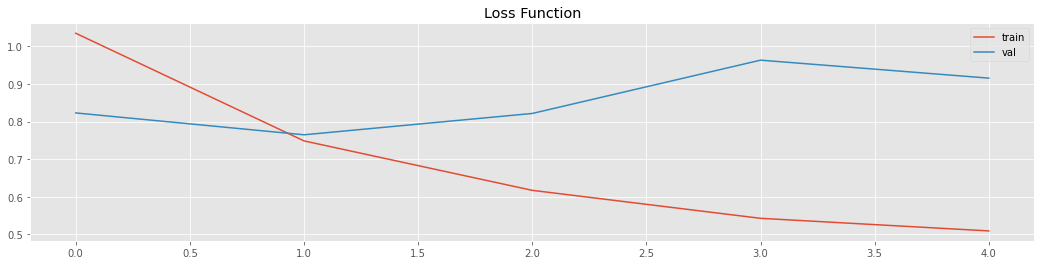

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(18, 4))
plt.plot(data_his['loss'], label = 'train')
plt.plot(data_his['val_loss'], label = 'val')
plt.legend()
plt.title('Loss Function')
plt.show()
fig.savefig("Loss Function",dpi=700)


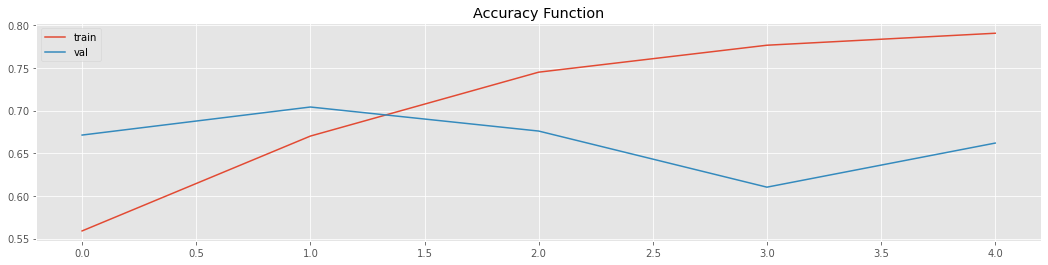

In [ ]:
fig = plt.figure(figsize=(18, 4))
plt.plot(data_his['accuracy'], label = 'train')
plt.plot(data_his['val_accuracy'], label = 'val')
plt.legend()
plt.title('Accuracy Function')
plt.show()
fig.savefig("Accuracy Function",dpi=700)

In [ ]:
train_images.class_indices.keys()

dict_keys(['autumn', 'spring', 'summer', 'winter'])

In [ ]:
train_images.class_indices.values()

dict_values([0, 1, 2, 3])

In [ ]:
model.save("/content/drive/MyDrive/2023 KUIAI 해커톤/man_season_tag_classificator.h5")

# 모델 성능 검증

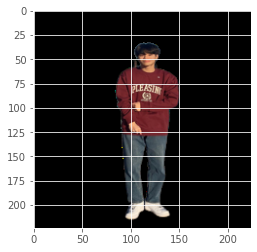

1/1 [==============================] - 0s 179ms/step
[2]


In [ ]:
from tensorflow.keras.preprocessing import image
dir_path = '/content/drive/MyDrive/2023 KUIAI 해커톤/influ_man_half/@m_n__day_6_half.png'

img = image.load_img(dir_path, target_size=(224,224))
plt.imshow(img)
plt.show()
    
X = image.img_to_array(img)
X = np.expand_dims(X,axis=0)
images = np.vstack([X])
predictions = np.argmax(model.predict(images), axis=1)
print(predictions)